In [283]:
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import pandas as pd  
import numpy as np  

import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

from base.JuUnits import parallal_task,task_chunk_split
from base.JuUnits import excute_for_multidates


from QUANTAXIS.QAUtil import DATABASE
from QUANTAXIS.QAUtil import  trade_date_sse
from QUANTAXIS.QAUtil.QADate_trade import (
    QA_util_get_pre_trade_date,
    QA_util_get_next_trade_date,
    QA_util_if_tradetime
)

import ind.alpha191 as a191
from scipy import stats
from sklearn import preprocessing
import statsmodels.api as sm



%load_ext autoreload
%autoreload 2
%aimport tools.Cacher


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [357]:
def pretreate_data(data):
    returns = smpl.get_current_return(data,'close')
    returns.name = 'returns'
    ret_forward = smpl.get_forward_return(data,'close')
    ret_forward.name = 'ret_forward'
    # {'Open', 'cap', 'close', 'high', 'ind', 'low', 'returns', 'volume', 'vwap'}
    data = pd.concat([data, returns, ret_forward], axis=1)
    data = data.assign(vwap=data.amount/(data.volume*100))
    data = smpl.add_marketvalue_industry(data)
    data.rename(columns = {"open":"Open",'totalCapital':'cap','industry':'ind'}, inplace=True)
    
    data.rename(columns = {"open":"Open"}, inplace=True)
    data = smpl.add_report_inds(data,'netAssetsPerShare')
    data['pb']=data['close']/data['netAssetsPerShare']
    return data
    # return pd.concat([data, close_ind, vwap_ind, low_ind, high_ind, volume_ind, adv20_ind, adv40_ind, adv81_ind, co_mixed_ind, oh_mixed_ind, lv_mixed_ind], axis=1)




In [16]:
def assemble_stocks_by_codes(codes):
    files = list(map(lambda x:x+'_train_qfq',l))
    return pd.concat(list(map(lambda file:load_cache(file,cache_type=CACHE_TYPE.STOCK),files))).sort_index(level=0)

l = smpl.get_codes_from_blockname('沪深300', sse='all')
df_all =  assemble_stocks_by_codes(l)

In [358]:
df_treated = pretreate_data(df_all)

In [20]:
# ids = [11,24,38,41,42,47,57,69,80,82,83,88,93,97]
ids = [11,24]

# ids = np.arange(1,101)
# np.random.shuffle(ids)

# def generate_alpha_factors(fun_ids, df=None):
#     import ind.alpha191 as a191
#     from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)
#     from base.JuUnits import excute_for_multidates

# for i in fun_ids:
for i in ids:
    fun_name = 'alpha'+ '0'*(3- int(np.log10(i)+1)) +str(i)
    # indx = excute_for_multidates(df, lambda x: getattr(a191, fun_name)(x) ,level=1)
    indx = excute_for_multidates(df_treated, lambda x: getattr(a191, fun_name)(x) ,level=1)
    indx.name = fun_name
    # save_cache('{}_train'.format(fun_name), indx, cache_type=CACHE_TYPE.FACTOR)
    print(indx)
# worker=6
# task = task_chunk_split(ids, worker)
# results = parallal_task(worker, generate_alpha_factors, task, df=df_treated)


code
000001   -4.506804e+07
000002    1.596329e+07
000063   -3.630724e+07
000066    3.796777e+06
000069    2.500154e+07
              ...     
603882   -1.483158e+05
603899   -2.834211e+06
603986    1.431323e+05
603993   -1.358729e+08
605499   -4.952623e+05
Name: alpha011, Length: 248, dtype: float64
code
000001   -0.406365
000002   -0.211400
000063    0.276363
000066    0.133742
000069    0.348468
            ...   
603882    1.635349
603899    1.838936
603986    0.895157
603993   -0.114700
605499   -1.127755
Name: alpha024, Length: 248, dtype: float64


In [692]:
# excute_for_multidates(df_treated.sort_index(), lambda x: a191.alpha011(x) ,level=1)
def STD(data, windows):
    return data.rolling(window=windows, min_periods=windows).std()
def MEAN(data, windows):
    return data.rolling(window=windows, min_periods=windows).mean()
def DELTA(data, windows):
    return data.diff(4)
def SEQUENCE(n):
    return np.arange(1,n+1)

def SMA(data,windows,alpha):
    return data.ewm(adjust=False, alpha=float(alpha)/windows, min_periods=windows, ignore_na=False).mean()

def REGBETA(xs, y, n):
    assert len(y)==n,  'len(y)!=n !!!'
    def reg(X,Y):
        try:
            res = sm.OLS(Y, X).fit().params
        except Exception as e:
            return np.nan
        return res
    return xs.rolling(window=n, min_periods=n).apply(lambda x:reg(x,y))

def COVIANCE(A,B,d):
    se = pd.Series(np.arange(len(A.index)),index=A.index)
    se = se.rolling(5).apply(lambda x: A.iloc[x].cov(B.iloc[x]))
    return se

def CORR(A,B,d):
    se = pd.Series(np.arange(len(A.index)),index=A.index)
    se = se.rolling(5).apply(lambda x: A.iloc[x].corr(B.iloc[x]))
    return se


def alpha090(data, dependencies=['amount', 'volume'], max_window=5):
    # (RANK(CORR(RANK(VWAP),RANK(VOLUME),5))*-1)
    return CORR(data['high'].rank(pct=True),data['volume'].rank(pct=True),5)*-1

print(alpha090(df_treated.loc[(slice(None),['000001']),:]).to_list()[0:100])
# df_treated.index.get_level_values(1).unique()

[nan, nan, nan, nan, -0.6977407183259708, -0.6495725101600099, -0.5167825923634336, -0.7495483759906155, 0.28333086907104904, 0.6108316679677247, 0.46281994189363906, 0.7250257546025772, 0.8209514978525327, 0.7803961764631745, 0.7402118616328145, 0.04931237523317875, -0.20497294314787756, 0.3180272553654844, 0.0058393368825910025, -0.22825300005477153, 0.09516665667622837, 0.20221677463985033, -0.37884971275054025, -0.9712307678067038, -0.7093332057122299, -0.899688717375226, -0.5222269834711215, -0.38382809838946585, -0.7821534170467566, -0.7165715700808901, -0.6736395595766456, -0.4902484553180352, -0.6453889077154285, -0.6720805648109706, -0.10449417396613438, 0.8003427633057172, 0.5239323170588175, -0.3878030442960804, -0.18222208000316145, -0.2931082007865443, -0.6146248016165031, -0.05367806720901446, 0.2721742320451014, 0.0004530990711832015, -0.22054073232371713, -0.6419915317074526, -0.7821249962968652, 0.04575177096120491, 0.0697339707329557, -0.2457300316609612, -0.533921249

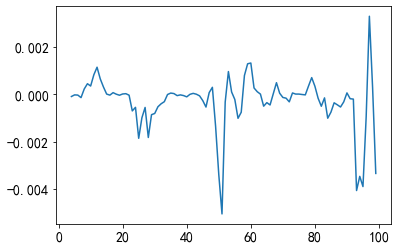

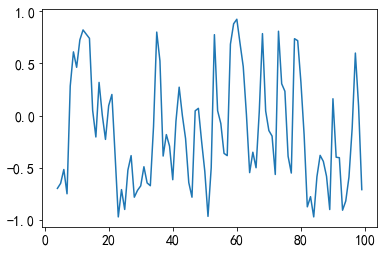

In [696]:
# df_all.loc[(slice('2017-01-10'),['000001','000002','000063']),:]
# pd.concat(indxes,axis=1).sort_index().loc[(slice('2017-01-15'),['000001','000002','000063']),:]

# # a = load_cache('alpha11_train', cache_type=CACHE_TYPE.FACTOR)
# # b = load_cache('alpha24_train', cache_type=CACHE_TYPE.FACTOR)
# pd.concat([a,b],axis=1).sort_index().loc[(slice('2017-01-20'),['000001','000002']),:]
# pd.Series(-1,index=df_treated.loc[(slice(None),['000001']),:].index,dtype=np.dtype('int8'))

# a=alpha004(df_treated.loc[(slice(None),['000001']),:])
# a.rolling(window=5, min_periods=5).corr(a).to_list()
# a.to_list()
# a.rolling(window=5, min_periods=5).apply(lambda x:x.corr(a[x.index])).to_list()
# a[0:50].rolling(window=5, min_periods=5).apply(lambda x:print(x.corr(a[x.index])))


# def alpha083(data, dependencies=['high', 'volume'], max_window=5):
#     # (-1*RANK(COVIANCE(RANK(HIGH),RANK(VOLUME),5)))
#     alpha = COVIANCE(data['high'].rank(pct=True),data['volume'].rank(pct=True),5)*-1
#     return alpha

# print(alpha083(df_treated.loc[(slice(None),['000001']),:]).to_list()[0:100])

import matplotlib.pyplot as plt
plt.plot(np.arange(100),alpha083(df_treated.loc[(slice(None),['000001']),:]).to_list()[0:100])
plt.show()
plt.plot(np.arange(100),alpha090(df_treated.loc[(slice(None),['000001']),:]).to_list()[0:100])
plt.show()